In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from skimage import io, color

%matplotlib inline

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 60000
NUM_VAL = 5000
batch_size = 64


trainset = dset.ImageFolder(root='./data/tiny-imagenet-200/train',
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

testset =  dset.ImageFolder(root='./data/tiny-imagenet-200/test',
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/tiny-imagenet-200/train'

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 

def color2gray(img):
    r, g, b = img[:,0,:,:], img[:,1,:,:], img[:,2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = gray.unsqueeze(1)
    return gray  #return batchsize*1*height*width

def grayshow(img):
    img = img / 2 + 0.5     # unnormalize
    gray = img.cpu().numpy()
    plt.imshow(np.transpose(gray, (1, 2, 0)), cmap='gray')
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
#show gray images
gray = color2gray(images)
print(gray.size())
grayshow(torchvision.utils.make_grid(gray))
plt.show()

NameError: name 'trainloader' is not defined

In [7]:
# Hyper parameters
NOISE_DIM = 96

# CPU or GPU
dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [8]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    # torch.rand generates in range (0, 1), hence using scale and shift to get to range (-1, 1)
    noise = torch.rand(batch_size, dim) * 2.0 - 1.0
    return noise

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [9]:
class netD(nn.Module):
    def __init__(self, N=batch_size, C=3, H=64, W=64):
        super(netD, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        self.layer1 = nn.Sequential(nn.Conv2d(self.C, self.H, 4, 2, 1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(self.H, self.H* 2, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 2),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(self.H * 2, self.H * 4, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 4),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(self.H * 4, self.H * 8, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 8),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer5 = nn.Sequential(nn.Conv2d(self.H * 8, 1, 4, 1, 0, bias=False),
                                 nn.Sigmoid())
        
    def forward(self, x):
        out = self.layer1(x) #64*64*32*32
        out = self.layer2(out) #64*128*16*16
        out = self.layer3(out) #64*256*8*8
        out = self.layer4(out) #64*512*4*4
        out = self.layer5(out) #64*1*1*1
        out = out.squeeze(2)
        out = out.squeeze(2)
        return out

D = netD().type(dtype)
c = Variable(trainloader.__iter__().next()[0]).type(dtype) #true
f = Variable(torch.Tensor(batch_size, 3, 64, 64)).type(dtype) #test random noise
out = D(c)
fout = D(f)
print(out.size())
print(fout.size())

NameError: name 'trainloader' is not defined

In [15]:
class netG(nn.Module):
    def __init__(self, N=batch_size, C=2, H=64, W=64, Zdim=96):
        super(netG, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        self.Z = Zdim
        self.project = nn.Linear(Zdim, self.H*self.H)
        self.zlayer = nn.Sequential(nn.BatchNorm2d(1),
                                 nn.ReLU(True))
        self.layer1 = nn.Sequential(nn.Conv2d(self.C, self.H, 4, 2, 1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(self.H, self.H* 2, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 2),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(self.H * 2, self.H * 4, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 4),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(self.H * 4, self.H * 8, 4, 2, 1, bias=False),
                                 nn.BatchNorm2d(self.H * 8),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer5 = nn.Sequential(nn.Conv2d(self.H * 8, self.H*8, 1, 1, 0, bias=False),
                                 nn.BatchNorm2d(self.H * 8),
                                 nn.LeakyReLU(0.2, inplace=True))
        self.layer6 = nn.Sequential(nn.ConvTranspose2d(self.H*8, self.H*4, 4, 2, 1),
                                 nn.BatchNorm2d(self.H*4),
                                 nn.ReLU(True))
        self.layer7 = nn.Sequential(nn.ConvTranspose2d(self.H*4, self.H*2, 4, 2, 1),
                                 nn.BatchNorm2d(self.H*2),
                                 nn.ReLU(True))
        self.layer8 = nn.Sequential(nn.ConvTranspose2d(self.H*2, self.H, 4, 2, 1),
                                 nn.BatchNorm2d(self.H),
                                 nn.ReLU(True))
        self.layer9 = nn.Sequential(nn.ConvTranspose2d(self.H, 3, 4, 2, 1),
                                 nn.BatchNorm2d(3),
                                 nn.Tanh(),
                                 )
    def forward(self, x):
        #project z
        b = x.size(0)
        z = Variable(sample_noise(b, self.Z)).type(dtype)
        z = self.project(z)
        z = z.view(b, 1, self.H, self.H)
        z = self.zlayer(z)
        out = torch.cat((x, z),1)
        out = self.layer1(out) #64*64*32*32
        out = self.layer2(out) #64*128*16*16
        out = self.layer3(out) #64*256*8*8
        out = self.layer4(out) #64*512*4*4
        out = self.layer5(out) #64*512*4*4
        out = self.layer6(out) #64*256*8*8
        out = self.layer7(out) #64*128*16*16
        out = self.layer8(out) #64*3*35*35
        out = self.layer9(out) #64*3*64*64
        return out

G = netG().type(dtype)
#g =  color2gray(trainloader.__iter__().next()[0][0].unsqueeze(0))
g = torch.Tensor(64, 1, 64, 64)
g = Variable(g).type(dtype) #gray bersion of true
#print(g.size())
#z = Variable(sample_noise(batch_size, dim=96)).type(dtype)
out = G(g)
print(out.size())

torch.Size([64, 3, 64, 64])


In [8]:
def g_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

def d_optimizer(model):
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999))
    return optimizer

In [9]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    # bce_loss(input, target) = target * -log(sigmoid(input)) + (1 - target) * -log(1 - sigmoid(input))
    
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [10]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    N_real = logits_real.size()
    N_fake = logits_fake.size()
    
    true_labels = Variable(torch.ones(N_real)).type(dtype)
    false_labels = Variable(torch.zeros(N_fake)).type(dtype)
    
    loss_real = bce_loss(logits_real, true_labels)
    loss_fake = bce_loss(logits_fake, false_labels)
    
    loss = loss_real + loss_fake
    return loss

tlogits_real = Variable(torch.Tensor(64, 1)).type(dtype)
tlogits_fake = Variable(torch.Tensor(64, 1)).type(dtype)
discriminator_loss(tlogits_real, tlogits_fake)

Variable containing:
 2.7764e+34
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [14]:
def generator_loss(logits_fake, fake_img, real_img, L1weight=5, rareweight=0.01):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    N = logits_fake.size()
    fake_true_labels = Variable(torch.ones(N)).type(dtype)
    
    #L1 loss
    fkv = fake_img.view(batch_size, 3, 64, 64)
    rv = real_img.view(batch_size, 3, 64, 64)
    l = torch.abs(fkv - rv)
    l1loss = l.sum()/(batch_size*3*64*64)

    loss = bce_loss(logits_fake, fake_true_labels) + l1loss*L1weight
    #loss = bce_loss(logits_fake, fake_true_labels)
    return loss, bce_loss(logits_fake, fake_true_labels), l1loss*L1weight

logits_fake = Variable(torch.Tensor(batch_size, 1)).type(dtype)
fake_img = Variable(torch.Tensor(batch_size, 3, 64, 64)).type(dtype)
real_img = Variable(torch.Tensor(batch_size, 3, 64, 64)).type(dtype)
generator_loss(logits_fake, fake_img, real_img, 5)

(Variable containing:
 nan
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  2.8757e+13
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 nan
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [13]:
def pytorch_plot_losses(loss_history1=None, loss_history2=None, 
                                        test_loss_history1=None, test_loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue")
    if test_loss_history1:
        ax1.plot(test_loss_history1, color="green")
    ax2 = ax1.twinx()
    if loss_history2:
        ax2.plot(loss_history2, color="red")
    if test_loss_history2:
        ax2.plot(test_loss_history2, color="black")
    #ax2.set_yscale('log')
    plt.savefig('imagenet_output_losses.png')

In [20]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=1000, 
              batch_size=64, noise_size=96, num_epochs=5):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    D_losses = []
    epoch_D_losses = []
    G_losses = []
    epoch_G_losses = []
    bce_losses = []
    epoch_b_losses = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in trainloader:
            if len(x) != batch_size:
                continue
            # update D
            D_solver.zero_grad()
            input_color = Variable(x).type(dtype)
            input_gray = Variable(color2gray(x)).type(dtype)

            logits_real = D(2* (input_color - 0.5)).type(dtype)
                        
            fake_images = G(input_gray).detach()
            logits_fake = D(fake_images.view(batch_size, 3, 64, 64))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()
            
            #update G
            G_solver.zero_grad()
            input_gray = Variable(color2gray(x)).type(dtype)
            fake_images = G(input_gray)
            gen_logits_fake = D(fake_images.view(batch_size, 3, 64, 64))
            g_error, bloss, L1loss = generator_loss(gen_logits_fake, fake_images, input_color, 1)
            g_error.backward()
            G_solver.step()
            
            #plot
            D_losses.append(d_total_error.cpu().data.numpy()[0])
            G_losses.append(g_error.cpu().data.numpy()[0])
            bce_losses.append(bloss.cpu().data.numpy())
            
            if (iter_count % show_every == 0):
                imshow(torchvision.utils.make_grid(x.view(batch_size,3,64,64)))
                plt.show()
                grayshow(torchvision.utils.make_grid(color2gray(x).view(batch_size,1,64,64)))
                plt.show()
                print('Epoch:{}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count,d_total_error.data[0],g_error.data[0]))
                imshow(torchvision.utils.make_grid(fake_images.data.view(batch_size,3,64,64)))
                plt.show()
                print()
            iter_count += 1
        epoch_D_losses.append(np.mean(D_losses))
        epoch_G_losses.append(np.mean(G_losses))
        epoch_b_losses.append(np.mean(bce_losses))
    pytorch_plot_losses(loss_history1=epoch_G_losses, test_loss_history1=epoch_b_losses)

In [19]:
D_DC = netD().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = netG().type(dtype)
G_DC.apply(initialize_weights)

netG (
  (project): Linear (96 -> 4096)
  (zlayer): Sequential (
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True)
    (1): ReLU (inplace)
  )
  (layer1): Sequential (
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
  )
  (layer2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.2, inplace)
  )
  (layer3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.2, inplace)
  )
  (layer4): Sequential (
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.2, inplace)
  )
  (layer5): Sequential (
    (0): Conv2d(512, 512

In [18]:
D_DC_solver = d_optimizer(D_DC)
G_DC_solver = g_optimizer(G_DC)
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=20)

NameError: name 'd_optimizer' is not defined

In [23]:
#save models
torch.save(D_DC.state_dict(), 'D_net_imagenet.pkl')
torch.save(G_DC.state_dict(), 'G_net_imagenet.pkl')

In [20]:
# test models
D_DC.load_state_dict(torch.load('D_net_imagenet.pkl'))
G_DC.load_state_dict(torch.load('G_net_imagenet.pkl'))

AssertionError: Torch not compiled with CUDA enabled

torch.Size([64, 3, 64, 64])


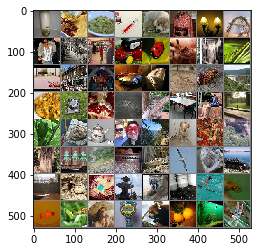

torch.Size([64, 1, 64, 64])


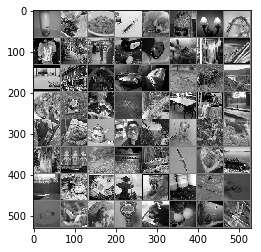

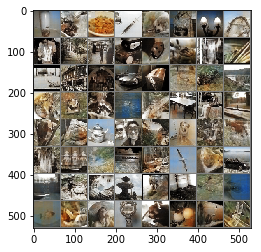

In [25]:
# get some random testing images
timages = testloader.__iter__().next()[0]
print(timages.size())
# show images
imshow(torchvision.utils.make_grid(timages))
plt.show()

#show gray images
tgray = color2gray(timages)
print(tgray.size())
grayshow(torchvision.utils.make_grid(tgray))
plt.show()

tgray = Variable(tgray).type(dtype)
gimg = G_DC(tgray).data.view(batch_size, 3, 64, 64)
imshow(torchvision.utils.make_grid(gimg))
plt.show()

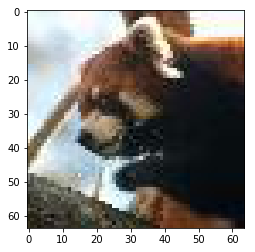

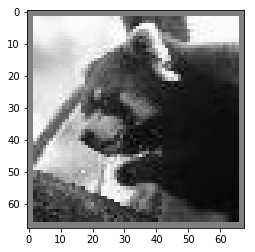

torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 64, 64])


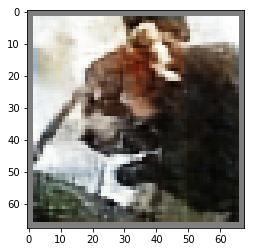

In [41]:
t1 = testloader.__iter__().next()[0][60]
imshow(torchvision.utils.make_grid(t1))
plt.show()
t1g = color2gray(t1.unsqueeze(0))
grayshow(torchvision.utils.make_grid(t1g))
plt.show()
t1gv = Variable(t1g).type(dtype)
print(t1gv.size())
t1gc = G_DC(t1gv)
print(t1gc.size())
imshow(torchvision.utils.make_grid(t1gc.data))
plt.show()